In [3]:
pip install rdkit 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 53.5 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install chembl_webresource_client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 4.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np

In [8]:
print("Search for target protein (EGFR)...")
target = new_client.target
target_query = target.search('EGFR')
targets = pd.DataFrame.from_dict(target_query)
# Select the first result (usually the correct single protein)
selected_target = targets.iloc[0]['target_chembl_id']
print(f"Target found: {selected_target}")

Search for target protein (EGFR)...
Target found: CHEMBL3608


In [9]:
print("Fetching bioactivity data (this may take a moment)...")
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

Fetching bioactivity data (this may take a moment)...


In [13]:
df = pd.DataFrame.from_dict(res)
print(f"Raw data fetched: {df.shape[0]} compounds")
df.head()

Raw data fetched: 97 compounds


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,110221,[],CHEMBL675511,Inhibition of epidermal growth factor receptor...,B,None,None,BAO_0000190,...,Mus musculus,Epidermal growth factor receptor,10090,None,None,IC50,uM,UO_0000065,None,100.0
1,None,None,113118,[],CHEMBL675511,Inhibition of epidermal growth factor receptor...,B,None,None,BAO_0000190,...,Mus musculus,Epidermal growth factor receptor,10090,None,None,IC50,uM,UO_0000065,None,100.0
2,None,None,119387,[],CHEMBL675511,Inhibition of epidermal growth factor receptor...,B,None,None,BAO_0000190,...,Mus musculus,Epidermal growth factor receptor,10090,None,None,IC50,uM,UO_0000065,None,100.0
3,None,None,133319,[],CHEMBL675511,Inhibition of epidermal growth factor receptor...,B,None,None,BAO_0000190,...,Mus musculus,Epidermal growth factor receptor,10090,None,None,IC50,uM,UO_0000065,None,25.0
4,None,None,193384,[],CHEMBL675513,Inhibition of epidermal growth factor receptor...,B,None,None,BAO_0000190,...,Mus musculus,Epidermal growth factor receptor,10090,None,None,IC50,uM,UO_0000065,None,0.07


In [14]:
df = df[df.standard_value.notna()]
df = df[df.canonical_smiles.notna()]
df.head()

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,110221,[],CHEMBL675511,Inhibition of epidermal growth factor receptor...,B,None,None,BAO_0000190,...,Mus musculus,Epidermal growth factor receptor,10090,None,None,IC50,uM,UO_0000065,None,100.0
1,None,None,113118,[],CHEMBL675511,Inhibition of epidermal growth factor receptor...,B,None,None,BAO_0000190,...,Mus musculus,Epidermal growth factor receptor,10090,None,None,IC50,uM,UO_0000065,None,100.0
2,None,None,119387,[],CHEMBL675511,Inhibition of epidermal growth factor receptor...,B,None,None,BAO_0000190,...,Mus musculus,Epidermal growth factor receptor,10090,None,None,IC50,uM,UO_0000065,None,100.0
3,None,None,133319,[],CHEMBL675511,Inhibition of epidermal growth factor receptor...,B,None,None,BAO_0000190,...,Mus musculus,Epidermal growth factor receptor,10090,None,None,IC50,uM,UO_0000065,None,25.0
4,None,None,193384,[],CHEMBL675513,Inhibition of epidermal growth factor receptor...,B,None,None,BAO_0000190,...,Mus musculus,Epidermal growth factor receptor,10090,None,None,IC50,uM,UO_0000065,None,0.07


In [15]:
df = df.drop_duplicates(['canonical_smiles'])
print(f"Cleaned data {df.shape[0]} unique compunds")

Cleaned data 91 unique compunds


In [19]:
def get_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mw = Descriptors.MolWt(mol)
        logp = Descriptors.MolLogP(mol)
        return mw, logp
    else:
        return None, None

In [21]:
df_sample = df.head(500).copy()

In [22]:
descriptors = df_sample['canonical_smiles'].apply(get_descriptors)
descriptors

0       (622.7719999999999, 7.991200000000005)
1      (562.7200000000003, 7.9740000000000055)
2     (282.36800000000005, 3.1861000000000015)
3       (564.6960000000003, 6.764000000000005)
4       (357.2150000000001, 4.544800000000002)
                        ...                   
91      (451.9350000000001, 4.848500000000004)
92     (464.83100000000013, 5.549700000000003)
94      (446.9100000000004, 4.275600000000003)
95      (393.4430000000002, 3.405100000000002)
96      (558.8690000000005, 5.235100000000005)
Name: canonical_smiles, Length: 91, dtype: object

Generating plot...


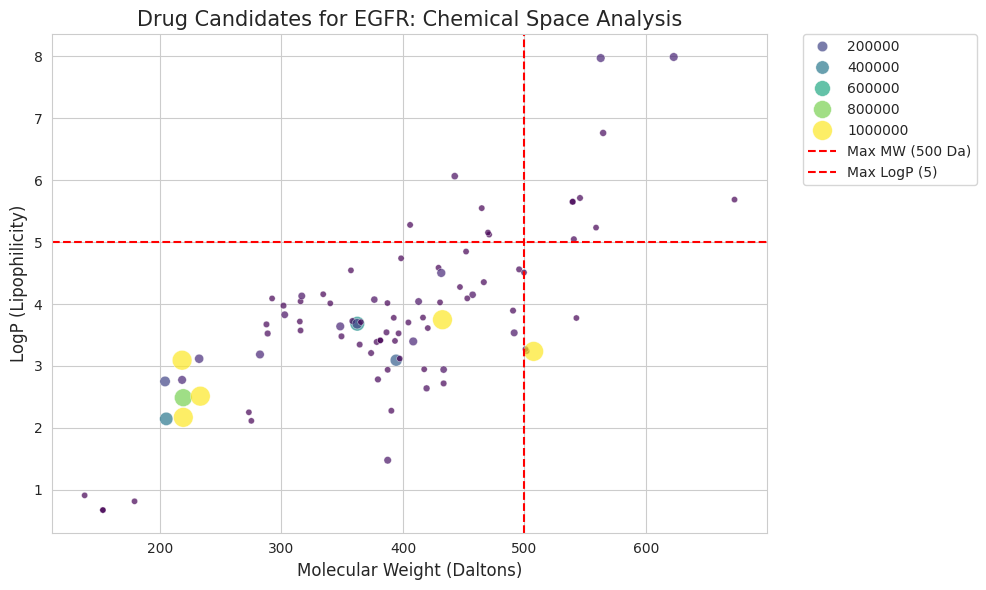

In [23]:
# Split the results into two columns
df_sample['MW'], df_sample['LogP'] = zip(*descriptors)

# --- STEP 4: VISUALIZATION ---
print("Generating plot...")

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Convert standard_value to numeric for plotting sizing
df_sample['standard_value'] = pd.to_numeric(df_sample['standard_value'], errors='coerce')

# Create a Scatter Plot: LogP vs Molecular Weight
sns.scatterplot(x='MW', y='LogP', data=df_sample, hue='standard_value', size='standard_value', sizes=(20, 200), alpha=0.7, palette="viridis")

# Add Lipinski's Rule Boundaries
plt.axvline(x=500, color='red', linestyle='--', label='Max MW (500 Da)')
plt.axhline(y=5, color='red', linestyle='--', label='Max LogP (5)')

plt.title('Drug Candidates for EGFR: Chemical Space Analysis', fontsize=15)
plt.xlabel('Molecular Weight (Daltons)', fontsize=12)
plt.ylabel('LogP (Lipophilicity)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.show()

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from rdkit.Chem import AllChem

In [25]:
df['standard_value'] = pd.to_numeric(df['standard_value'], errors='coerce')
df_clean = df.dropna(subset=['standard_value']) # Drop any remaining errors

In [26]:
df_clean.head()

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,110221,[],CHEMBL675511,Inhibition of epidermal growth factor receptor...,B,None,None,BAO_0000190,...,Mus musculus,Epidermal growth factor receptor,10090,None,None,IC50,uM,UO_0000065,None,100.0
1,None,None,113118,[],CHEMBL675511,Inhibition of epidermal growth factor receptor...,B,None,None,BAO_0000190,...,Mus musculus,Epidermal growth factor receptor,10090,None,None,IC50,uM,UO_0000065,None,100.0
2,None,None,119387,[],CHEMBL675511,Inhibition of epidermal growth factor receptor...,B,None,None,BAO_0000190,...,Mus musculus,Epidermal growth factor receptor,10090,None,None,IC50,uM,UO_0000065,None,100.0
3,None,None,133319,[],CHEMBL675511,Inhibition of epidermal growth factor receptor...,B,None,None,BAO_0000190,...,Mus musculus,Epidermal growth factor receptor,10090,None,None,IC50,uM,UO_0000065,None,25.0
4,None,None,193384,[],CHEMBL675513,Inhibition of epidermal growth factor receptor...,B,None,None,BAO_0000190,...,Mus musculus,Epidermal growth factor receptor,10090,None,None,IC50,uM,UO_0000065,None,0.07


In [27]:
df_clean['activity_label'] = [1 if x < 1000 else 0 for x in df_clean['standard_value']]
print(f"Active compounds: {df_clean[df_clean['activity_label']==1].shape[0]}")
print(f"Inactive compounds: {df_clean[df_clean['activity_label']==0].shape[0]}")

Active compounds: 29
Inactive compounds: 62


In [28]:
def get_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        # Radius 2 is standard (similar to ECFP4)
        return AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    else:
        return None

In [29]:
print("Generating molecular fingerprints (this is the heavy math)...")
df_clean['fingerprint'] = df_clean['canonical_smiles'].apply(get_fingerprint)

Generating molecular fingerprints (this is the heavy math)...


[21:56:40] DEPRECATION WARNING: please use MorganGenerator
[21:56:40] DEPRECATION WARNING: please use MorganGenerator
[21:56:40] DEPRECATION WARNING: please use MorganGenerator
[21:56:40] DEPRECATION WARNING: please use MorganGenerator
[21:56:40] DEPRECATION WARNING: please use MorganGenerator
[21:56:40] DEPRECATION WARNING: please use MorganGenerator
[21:56:40] DEPRECATION WARNING: please use MorganGenerator
[21:56:40] DEPRECATION WARNING: please use MorganGenerator
[21:56:40] DEPRECATION WARNING: please use MorganGenerator
[21:56:40] DEPRECATION WARNING: please use MorganGenerator
[21:56:40] DEPRECATION WARNING: please use MorganGenerator
[21:56:40] DEPRECATION WARNING: please use MorganGenerator
[21:56:40] DEPRECATION WARNING: please use MorganGenerator
[21:56:40] DEPRECATION WARNING: please use MorganGenerator
[21:56:40] DEPRECATION WARNING: please use MorganGenerator
[21:56:40] DEPRECATION WARNING: please use MorganGenerator
[21:56:40] DEPRECATION WARNING: please use MorganGenerat

In [35]:
df_ml = df_clean.dropna(subset=['fingerprint'])

In [37]:
df_ml.head()

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value,activity_label,fingerprint
0,None,None,110221,[],CHEMBL675511,Inhibition of epidermal growth factor receptor...,B,None,None,BAO_0000190,...,10090,None,None,IC50,uM,UO_0000065,None,100.0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,None,None,113118,[],CHEMBL675511,Inhibition of epidermal growth factor receptor...,B,None,None,BAO_0000190,...,10090,None,None,IC50,uM,UO_0000065,None,100.0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,None,None,119387,[],CHEMBL675511,Inhibition of epidermal growth factor receptor...,B,None,None,BAO_0000190,...,10090,None,None,IC50,uM,UO_0000065,None,100.0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,None,None,133319,[],CHEMBL675511,Inhibition of epidermal growth factor receptor...,B,None,None,BAO_0000190,...,10090,None,None,IC50,uM,UO_0000065,None,25.0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,None,None,193384,[],CHEMBL675513,Inhibition of epidermal growth factor receptor...,B,None,None,BAO_0000190,...,10090,None,None,IC50,uM,UO_0000065,None,0.07,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [40]:
X = np.array(list(df_ml['fingerprint']))
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [41]:
y=df_ml['activity_label'].values
y

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1])

In [59]:
print("Training Random Forest Model...")

# Split: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# --- STEP 7: EVALUATE ---
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

Training Random Forest Model...


In [60]:
print("--- MODEL RESULTS ---")
print(f"Accuracy: {accuracy:.2%}") # How often is it right?
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

--- MODEL RESULTS ---
Accuracy: 94.74%

Confusion Matrix:
[[12  0]
 [ 1  6]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.86      0.92         7

    accuracy                           0.95        19
   macro avg       0.96      0.93      0.94        19
weighted avg       0.95      0.95      0.95        19



In [64]:
new_drug_smiles = "C1=CC=C(C=C1)C=NC2=CC=CC=C2" 
new_fp = [get_fingerprint(new_drug_smiles)]


[22:42:24] DEPRECATION WARNING: please use MorganGenerator


In [65]:
import py3Dmol
from rdkit import Chem
from rdkit.Chem import AllChem

# 1. Define the molecule (Gefitinib)
smiles = new_drug_smiles
mol = Chem.MolFromSmiles(smiles)

# 2. Prepare for 3D
# Add Hydrogens (Crucial for 3D geometry, as they define the shape)
mol_3d = Chem.AddHs(mol)

# Calculate 3D coordinates (Embedding)
# This simulates how the atoms arrange themselves in space
AllChem.EmbedMolecule(mol_3d, AllChem.ETKDG()) 

# optimize the geometry (Make it physically realistic)
AllChem.MMFFOptimizeMolecule(mol_3d)

# 3. Create the Viewer
# Convert the RDKit object to a text block that py3Dmol can read
mol_block = Chem.MolToMolBlock(mol_3d)

# Initialize viewer
view = py3Dmol.view(width=600, height=400)
view.addModel(mol_block, 'mol')

# Style the molecule
# 'stick': shows bonds
# 'sphere': shows atoms (colored by element: Gray=C, Red=O, Blue=N, etc.)
view.setStyle({'stick': {}}) 

# Highlight the Fluorine (Green) and Chlorine (Green) explicitly if needed, 
# but default coloring usually handles this well.

view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [66]:
prediction = rf.predict(new_fp)
probability = rf.predict_proba(new_fp)

label = "ACTIVE" if prediction[0] == 1 else "INACTIVE"
confidence = probability[0][prediction[0]]

print(f"Testing new molecule: {new_drug_smiles[:20]}...")
print(f"Model Prediction: {label}")
print(f"Confidence: {confidence:.2%}")

Testing new molecule: C1=CC=C(C=C1)C=NC2=C...
Model Prediction: INACTIVE
Confidence: 71.00%


In [67]:
import pickle

with open('drug_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

print("Model saved as 'drug_model.pkl'. Download this file to your computer!")

Model saved as 'drug_model.pkl'. Download this file to your computer!
